In [1]:

import pandas as pd
import numpy as np

import shutil
import sys
import os

# yoltv4_path = '/home/carlos/Python_Workspace/pcb-cv_detection/'
# sys.path.append(os.path.join(yoltv4_path, 'yoltv4'))
import yoltv4.prep_train as prep_train

# #import yoltv4.tile_ims_labels as tile_ims_labels
# #import yoltv4.post_process
# #reload(prep_train)

# from yolov3.utils import detect_image, detect_realtime, detect_video, Load_Yolo_model, detect_video_realtime_mp
from yolov3.configs import *

from yolt_extension import rescale, slice_images, post_process, slice_single_image
import detector

import json
import skimage.io


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14221250465493585813
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18018636280891906327
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3050779444
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5022181504640693
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:27:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13944551399432755435
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
## TEST Tensorflow Configuration

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')


Num GPUs Available:  1


In [4]:
### CONFIGURATION ###

# set dataset path
##data_root = '/home/carlos/Python_Workspace/DATA/Component_Detection/TEST_DATA'
#data_root = "C:\\Users\\carlo\\Python_workspace\\DATA\\TRAIN_DATA"
#dataset_path = "C:\\Users\\carlo\\Python_workspace\\DATA\\Component_Detection_Dataset"

data_root = "DATA"
imgs_dir =  os.path.join("DATA", "train_images")

videos_names = ["video_0", "video_1" , "video_2"]

config_path = "model_data/"
current_class = "starfish"
# Path of classes name file
#classname_file_path =  '/home/carlos/Python_Workspace/DATA/Component_Detection/components.name'

# Image extension
img_ext = ".jpg"



In [5]:
# Load Data
train_file_path = os.path.join(data_root, "train.csv")

train_df = pd.read_csv(train_file_path)

In [6]:
train_df.head(5)

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

In [7]:
train_df = train_df.drop(columns=["sequence","sequence_frame","image_id"])

In [8]:

## Load Config File ##
config_filename = "config.json"
class_config_path = os.path.join(config_path, config_filename)
print(class_config_path)

config = json.loads(open(class_config_path, "r").read())


model_data/config.json


In [9]:
config["model"]["classes"] = {0: current_class}

In [10]:
from yolov3.yolov4 import read_class_names
config["model"]["classesOrig"] = read_class_names(config["data"]["classesOrig"])


KeyError: 'classesOrig'

from yolov3.yolov4 import read_class_names

config["model"]["classes"] = read_class_names("model_data/components.name")

print(classes)

In [11]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

#Function for obtaining the images in a folder
def get_images_dicts(directory):
    dataset_dicts = []
    for filename in [file for file in listdir_nohidden(directory) if not(file.endswith(".csv"))]:      
        dataset_dicts.append(filename)

    return dataset_dicts

In [12]:
train_df.head()

video_id  video_frame annotations
0         0            0          []
1         0            1          []
2         0            2          []
3         0            3          []
4         0            4          []

-----
## Prepare Data

Divide the scaled images in slices of 416x416 with stamps for recombining the data after.

In [13]:
# SLICE CONFIGURATION #
sliceHeight, sliceWidth = 416, 416
slice_overlap=0.2
out_ext = img_ext
verbose = False
slice_sep = "__"

# Folders for saving the temp data
data_root_tmp = os.path.join(data_root)
outdir_root = os.path.join(data_root_tmp, 'process_tmp_folder')
outdir_ims = os.path.join(outdir_root, 'images_slice')
outdir_labels = os.path.join(outdir_root, 'labels_slice')
outdir_txt = os.path.join(outdir_root, 'txt')

# If the folder exists it will be deleted
if os.path.exists(outdir_ims) != 0:
    print("Removing existing data")
    shutil.rmtree(outdir_ims)

# If the folder exists it will be deleted
if os.path.exists(outdir_labels) != 0:
    print("Removing existing data")
    shutil.rmtree(outdir_labels)


# Create the save folder if it does not exist
if os.path.exists(outdir_ims) == 0:
    os.makedirs(outdir_ims)


for i, row in train_df.iterrows(): 

    # slice images
    print(row)

    video_name = videos_names[int(row[0])]
    im_name = str(row[1])+".jpg"

    im_path = os.path.join(imgs_dir, video_name, im_name)

    print(im_path)

    im_tmp = skimage.io.imread(im_path)
    h, w = im_tmp.shape[:2]
    # tile data
    out_name = im_name.split('.')[0]

    # Create the save folder if it does not exist
    if os.path.exists(outdir_labels) == 0:
        os.makedirs(outdir_labels)

    anno = eval(row["annotations"])

    box_array = np.zeros((len(anno),4),dtype=int)

    for i,an in enumerate(anno):
        #  annos.append(an)
      
        # box_array[i][0] = an['x'] - (an['width'] / 2)
        # box_array[i][1] = an['x'] + (an['width'] / 2) 
        # box_array[i][3] = an['y'] - (an['height'] / 2)
        # box_array[i][2] = an['y'] + (an['height'] / 2)

        box_array[i][0] = (an['x'] )
        box_array[i][2] = (an['x'] + (an['width'] ) )
        box_array[i][1] = an['y'] 
        box_array[i][3] = an['y'] + (an['height'] )



    class_array = np.zeros(len(box_array),dtype=int)

    # for i,val in enumerate(box_array):
    #     print("{}:{}".format(i,val))

    print(box_array)
    print(class_array)

    slice_single_image(
        im_path, out_name, outdir_ims,
        sliceHeight=sliceHeight, sliceWidth=sliceWidth,
        overlap=slice_overlap,
        slice_sep=slice_sep,
        skip_highly_overlapped_tiles=False,
        overwrite=True,
        en_GT=True,
        boxes=box_array,
        classes=class_array,
        out_dir_labels=outdir_labels,
        out_ext=out_ext,
        verbose=verbose)

    train_df

    im_dir = os.path.join(imgs_dir, video_name)



   ##############





Removing existing data
Removing existing data
video_id        0
video_frame     0
annotations    []
Name: 0, dtype: object
DATA\train_images\video_0\0.jpg
[]
[]
Num slices: 12 sliceHeight 416 sliceWidth 416
Time to slice DATA\train_images\video_0\0.jpg 0.02101922035217285 seconds
video_id        0
video_frame     1
annotations    []
Name: 1, dtype: object
DATA\train_images\video_0\1.jpg
[]
[]
Num slices: 12 sliceHeight 416 sliceWidth 416
Time to slice DATA\train_images\video_0\1.jpg 0.01801586151123047 seconds
video_id        0
video_frame     2
annotations    []
Name: 2, dtype: object
DATA\train_images\video_0\2.jpg
[]
[]
Num slices: 12 sliceHeight 416 sliceWidth 416
Time to slice DATA\train_images\video_0\2.jpg 0.01801586151123047 seconds
video_id        0
video_frame     3
annotations    []
Name: 3, dtype: object
DATA\train_images\video_0\3.jpg
[]
[]
Num slices: 12 sliceHeight 416 sliceWidth 416
Time to slice DATA\train_images\video_0\3.jpg 0.018016576766967773 seconds
video_id     

KeyboardInterrupt: 

### Plot some slices with the boundary boxes

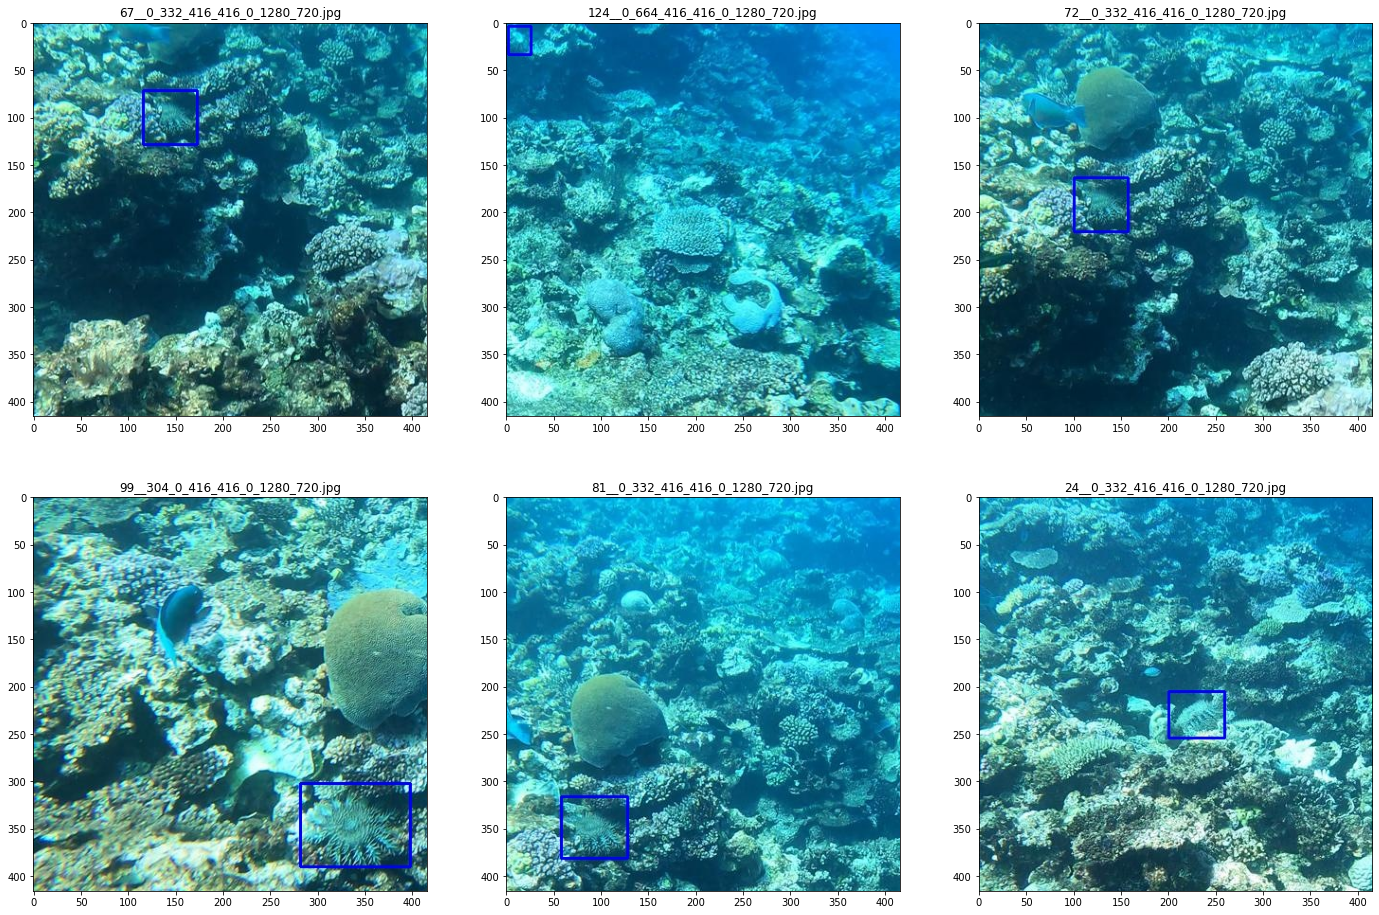

In [17]:
import random
import skimage.io
import matplotlib.pyplot as plt

## Visualize the data has been sliced correctly ##

outdir_yolt_plot = os.path.join(data_root_tmp, 'GT_plot_bbox')

# If the folder exists it will be deleted
if os.path.exists(outdir_yolt_plot) != 0:
    print("Removing existing data")
    shutil.rmtree(outdir_yolt_plot)

# Generate the images on disk
prep_train.plot_training_bboxes(
                        outdir_labels,
                        outdir_ims, 
                        ignore_augment=True,
                        figsize=(10, 10), 
                        color=(0, 0, 255), 
                        thickness=2,
                        max_plots=100, 
                        sample_label_vis_dir=outdir_yolt_plot, 
                        ext='.jpg',
                        show_plot=False, specific_labels=[],
                        label_dic=[], output_width=500, shuffle=True,
                        verbose=False)

# Plot on the Notebook some of them
dir_tmp = outdir_yolt_plot
rows, cols = 2, 3
figsize = 8
paths_tmp = [os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp) if j.endswith('.jpg')]
rand_selection = random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

### Format file for labels found

In [18]:
# Create the save folder if it does not exist
if os.path.exists(outdir_txt) == 0:
    os.makedirs(outdir_txt)

# CONFIGURATION
PROB_TEST = 0.1

# make list of all generated images path
im_list_test = []

# annot_str = ""
labels_txt = os.path.join(outdir_txt, 'train_list.txt')
annot_file_train = open(labels_txt, "w")

labels_txt = os.path.join(outdir_txt, 'test_list.txt')
annot_file_test = open(labels_txt, "w")

for f in sorted([z for z in os.listdir(outdir_ims) if z.endswith(out_ext)]):

    image_name = f.split(".")[0]
    image_path = os.path.realpath(os.path.join(outdir_ims, f))

    annot_str = image_path

    out_path_label = os.path.join(outdir_labels, image_name + ".txt")

    boxes_file = open(out_path_label, "r")

    boxes_text = boxes_file.read()

    boxes_lines = boxes_text.split("\n")

    for bbox_line in boxes_lines:

        if len(bbox_line) > 10:
            bbox_elements = bbox_line.split(" ")
            #print(bbox_elements)

            center_x    = float(bbox_elements[1])
            center_y    = float(bbox_elements[2])
            width       = float(bbox_elements[3])
            height      = float(bbox_elements[4])

            xmin = int(sliceWidth * (center_x - (width / 2)))
            ymin = int(sliceHeight * (center_y - (height / 2)))
            xmax = int(sliceWidth * (center_x + (width / 2)))
            ymax =  int(sliceHeight * (center_y + (height / 2)))
            class_ind = bbox_elements[0]


            annot_str += ' ' + ','.join([str(xmin), str(ymin), str(xmax), str(ymax), str(class_ind)])

    # Divide Random between train and test files
    rand_num = np.random.rand()

    if rand_num < PROB_TEST:
        print("=> %s" %annot_str)
        annot_file_test.write(annot_str + "\n")
    else:
        print("=> %s" %annot_str)
        annot_file_train.write(annot_str + "\n")

    
annot_file_test.close()
annot_file_train.close()


# # Save the list with the path of all images
# df_imgs_list = pd.DataFrame({'image': im_list_test})
# df_imgs_list.to_csv(os.path.join(outdir_txt, 'imgs_list.txt'), header=False, index=False)

=> /Volumes/Backup/Carlos/Proyectos/HighRes-YOLO/DATA/process_tmp_folder/images_slice/100__304_0_416_416_0_1280_720.jpg 276,327,392,415,0
=> /Volumes/Backup/Carlos/Proyectos/HighRes-YOLO/DATA/process_tmp_folder/images_slice/101__0_332_416_416_0_1280_720.jpg 308,52,330,72,0
=> /Volumes/Backup/Carlos/Proyectos/HighRes-YOLO/DATA/process_tmp_folder/images_slice/101__304_0_416_416_0_1280_720.jpg 266,355,382,415,0
=> /Volumes/Backup/Carlos/Proyectos/HighRes-YOLO/DATA/process_tmp_folder/images_slice/102__0_332_416_416_0_1280_720.jpg 308,50,330,70,0
=> /Volumes/Backup/Carlos/Proyectos/HighRes-YOLO/DATA/process_tmp_folder/images_slice/102__304_0_416_416_0_1280_720.jpg 263,376,379,415,0
=> /Volumes/Backup/Carlos/Proyectos/HighRes-YOLO/DATA/process_tmp_folder/images_slice/103__0_332_416_416_0_1280_720.jpg 310,49,330,70,0
=> /Volumes/Backup/Carlos/Proyectos/HighRes-YOLO/DATA/process_tmp_folder/images_slice/104__0_332_416_416_0_1280_720.jpg 310,46,332,68,0
=> /Volumes/Backup/Carlos/Proyectos/HighRe

___
## Train on Yolo

In this section we run Yolo over each of the images previously sliced. This part is based in the Yolo implemetation over TensorFlow from: [TensorFlow-2.x-YOLOv3](https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3)

In [15]:

detector.train(config)

GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ValueError: operands could not be broadcast together with shapes (10,) (3,) 

In [ ]:

outdir_localPred = os.path.join(outdir_root, 'local_predictions')

# If the folder contains data it will be deleted
if os.path.exists(outdir_localPred) != 0:
    print("Removing existing data")
    shutil.rmtree(outdir_localPred)

# Create the save folder if it does not exist
if os.path.exists(outdir_localPred) == 0:
    os.makedirs(outdir_localPred)


arr_pred = np.empty((7, 0))

#Load Yolo Model on memory
yolo = Load_Yolo_model()

print("Model Loaded")

for image_name in df_imgs_list['image']:
    image_path = os.path.join(outdir_ims, image_name)
    save_path = os.path.join(outdir_localPred, image_name)

    #Image name without extension
    img_name = image_name.split(".")[0]

    lst_elements_detected = detect_image(yolo, image_path, save_path, input_size=YOLO_INPUT_SIZE, show=False, CLASSES=YOLO_COCO_CLASSES, score_threshold=0.1, rectangle_colors=(255,0,0))

    if(len(lst_elements_detected)>0):

        elements_detected = np.array(lst_elements_detected)

        array_image_name = np.tile(np.array([image_name]),(elements_detected.shape[0]))

        # print(array_image_name.shape)
        # print(elements_detected.shape)
        # print(elements_detected)

        new_pred = np.concatenate(  [[array_image_name], 
                                    [elements_detected[:,4]], 
                                    [elements_detected[:,5]],
                                    [elements_detected[:,0]],
                                    [elements_detected[:,1]],
                                    [elements_detected[:,2]],
                                    [elements_detected[:,3]]],
                                    axis = 0)
        
        #print(arr_pred.shape)
        #print(new_pred.shape)

        arr_pred = np.append(arr_pred, new_pred, axis=1)

        

    print("Processed image: "+image_name)
    


In [ ]:
print(arr_pred.shape)

print(arr_pred[:,0:4])

In [ ]:
df_predictions = pd.DataFrame(np.rot90(arr_pred),columns=['im_name','prob','category','Xmin', 'Ymin', 'Xmax', 'Ymax'])
df_predictions = df_predictions.astype({'im_name':str,'prob':float,'category':str,'Xmin':float, 'Ymin':float, 'Xmax':float, 'Ymax':float})
df_predictions.head(10)

-----
## Process the results

In [ ]:
from detector import  post_process_predictions

###### CONFIGURATION #########
raw_im_dir=im_scaled_dir
im_ext='.jpg'
out_dir_root=os.path.join(outdir_root, 'yolt_predictions')
detection_thresh=0.2
slice_size=416
n_plots = 20
max_edge_aspect_ratio=2.5
nms_overlap_thresh=0.5

df_yolt_predictions = post_process_predictions(df_predictions,
                        raw_im_dir,
                        im_ext,
                        out_dir_root,
                        detection_thresh,
                        max_edge_aspect_ratio,
                        nms_overlap_thresh,
                        slice_size,
                        n_plots
                        )

-----
## Combine results with differents scales

In [ ]:
df_columns = ["Center_X","Center_Y","Width","Height","Prob","Level_1","Prob_L1","Level_2","Prob_L2","Level_3","Prob_L3","Class","Prob_Clas"]

images = get_images_dicts(im_dir)


#Loop for processing each image of the PCB found in the images folder
for img_filename in images:
    
    #Create the predictions DF for the board
    RES_DF = pd.DataFrame(columns=df_columns)

    #Image name without extension
    img_name = img_filename.split(".")[0]

    for index, pixel_density in enumerate(grid_pixels_density):

        img_scaled_name = img_name + "_" + str(pixel_density)
        print(img_scaled_name)

        # Exclude the predictions different from the current iteration data
        current_df = df_yolt_predictions.loc[df_yolt_predictions["im_name_root"]== (img_scaled_name)]

        DF = pd.DataFrame(columns=df_columns)

        # Calculate the size of the box in pixels
        DF["Width"] = current_df["Xmax_Glob"] - current_df["Xmin_Glob"]
        DF["Height"] = current_df["Ymax_Glob"] -current_df["Ymin_Glob"]
        DF["Center_X"] = current_df["Xmin_Glob"] + (DF["Width"] /2)
        DF["Center_Y"] = current_df["Im_Height"] - (current_df["Ymin_Glob"] + (DF["Height"] /2))

        # Calculate size in mm
        DF["Width"] = DF["Width"] / pixel_density
        DF["Height"] = DF["Height"] / pixel_density
        DF["Area"] = DF["Width"] * DF["Height"]
        DF["Center_X"] = DF["Center_X"] / pixel_density
        DF["Center_Y"] = DF["Center_Y"] / pixel_density

        DF["Prob"] = current_df["prob"] 

        pcbName = current_df["im_name_root"].iloc[0]
        print(pcbName)

        # Round the dataframe to 2 decimals
        DF = DF.round(3)

        # Exclude the detections outside the detection range
        DF = DF[(DF["Area"]<=max_size_density[index])] 
        DF = DF[(DF["Area"]>min_size_density[index])]

        DF = DF.drop(columns=["Area"])

        # Append the prediciton in the board DF
        RES_DF =  RES_DF.append(DF,ignore_index=True)

    # Save dataset
    df_path = os.path.join(data_root, img_name + ".csv")
    RES_DF.to_csv(df_path,index=True)


